## Some analysis of Delhi Pollution Data

The datasets for pollution data in many countries are readily available and there has been a bunch of research already done on those. I wanted to see if I could do some analysis of the pollution patterns of Indian cities. Unfortunately, I could not find an openly accessible historical pollution dataset for Indian cities. The folks over at [aqicn.org](http://aqicn.org) apparently provide access to institutions but not to individuals. In any case, I was able to locate a fantastic initiative by the [Delhi Pollution Control Committee](http://www.dpccairdata.com/dpccairdata/display/index.php). They provide *raw* pollution data from six sensor clusters inside the city. While the availability could be better, and all sensor clusters do not cover all the metrics, this kind of data is incredibly useful. Kudos to them for having made this available! One problem is that they do not provide historical data, so I had to aggregate the realtime data over time. What follows is some analysis of that data. Hopefully, as the dataset grows, we'd be able to derive more insights about the pollution situation in delhi.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import re

%matplotlib inline

### Munging

The data I am dumping out into the csv file below is pretty raw. It look like:

In [74]:
rawdata = pd.read_csv('./netfile.csv', names=['location', 'metric', 'ts', 'reading', 'guidance'])
rawdata.sort_values(['ts', 'location'])
rawdata.head()

,location,metric,ts,reading,guidance
0,Punjabi Bagh,Ammonia,1471960200,19.1 µg/m3,400 µg/m3
1,Punjabi Bagh,Benzene,1471960200,0.2 µg/m3,05 µg/m3 *
2,Punjabi Bagh,Carbon Monoxide,1471960200,1.2 mg/m3,04 mg/m3
3,Punjabi Bagh,Nitrogen Dioxide,1471960200,49.6 µg/m3,80 µg/m3
4,Punjabi Bagh,Nitrogen Oxide,1471960200,4.3 µg/m3,-


In [75]:
rawdata.location.value_counts()

IGI Airport     5580
Punjabi Bagh    5301
RK Puram        5301
Anand Vihar     5301
Civil Lines     3069
Name: location, dtype: int64

In [76]:
rawdata.metric.value_counts()

Benzene                                               1395
Carbon Monoxide                                       1395
Nitrogen Oxide                                        1395
Ozone                                                 1395
Ammonia                                               1395
Nitrogen Dioxide                                      1395
p-Xylene                                              1395
Sulphur Dioxide                                       1395
Toluene                                               1395
Wind Direction                                        1116
Relative Humidity                                      837
Particulate Matter < 2.5 µg                            837
Solar Radiation                                        837
Ambient Temperature                                    837
Vertical Wind Speed                                    837
Horizontal Wind Speed                                  837
Particulate Matter < 10 µg                             8

Some of these metrics sound inferable: for example *Nitrogen Dioxide* and *Nitrogen Oxide* should give a good estimate for *Oxides of Nitrogen* where it does not exist independently. However, we'll look at that later. For now, let's munge this into a more useful dataframe

In [77]:
rawdata['ts'] = pd.to_datetime(rawdata.ts, unit='s')

def mungeReading(x):
    return "".join([t[0] for t in re.findall("[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?", x)][:1]) if not (x.strip() == '-') else "coerce"

rawdata['reading'] = pd.to_numeric(rawdata.reading.apply(mungeReading), errors='coerce')
rawdata['guidance'] = pd.to_numeric(rawdata.guidance.apply(mungeReading), errors='coerce')

rawdata.head()

,location,metric,ts,reading,guidance
0,Punjabi Bagh,Ammonia,2016-08-23 13:50:00,19.1,400.0
1,Punjabi Bagh,Benzene,2016-08-23 13:50:00,0.2,5.0
2,Punjabi Bagh,Carbon Monoxide,2016-08-23 13:50:00,1.2,4.0
3,Punjabi Bagh,Nitrogen Dioxide,2016-08-23 13:50:00,49.6,80.0
4,Punjabi Bagh,Nitrogen Oxide,2016-08-23 13:50:00,4.3,NaN


In [78]:
rawdata.reading.isnull().sum(), len(rawdata.reading), rawdata.guidance.isnull().sum(), len(rawdata.guidance)

(1437, 24552, 14136, 24552)

So that looks reasonable and only a few readings are NaN. I expect that the guidance is a simple function of the metric and should not change that often. Let us check:

In [79]:
rawdata[['metric', 'guidance']].groupby('metric').guidance.value_counts()

metric                                             guidance
Ammonia                                            400.0       1386
                                                   3.0            9
Benzene                                            5.0         1395
Carbon Monoxide                                    4.0          723
                                                   3.0          114
Mass Concentration PM 10 (Previous Day's Average)  100.0        279
Nitrogen Dioxide                                   80.0        1382
                                                   3.0           13
Nitrogen Oxide                                     3.0           13
Oxides of Nitrogen                                 3.0           13
Ozone                                              180.0       1382
                                                   3.0           13
Particulate Matter < 10 µg                         100.0        825
                                                   3.0  

Woah, loooks like there are multiple guidances per metric. For 9 records, the guidance for Ammonia, which ought to be 400 was listed as 3.0. Let us check those records..

In [80]:
rawdata[(rawdata['metric'] == 'Ammonia') & (rawdata['guidance'] == 3.0)]

,location,metric,ts,reading,guidance
6814,RK Puram,Ammonia,2016-08-24 09:15:00,3.0,3.0
15174,RK Puram,Ammonia,2016-08-25 09:05:00,3.0,3.0
15262,RK Puram,Ammonia,2016-08-25 09:25:00,3.0,3.0
15350,RK Puram,Ammonia,2016-08-25 09:30:00,3.0,3.0
15507,Anand Vihar,Ammonia,2016-08-25 10:15:00,3.0,3.0
15595,Anand Vihar,Ammonia,2016-08-25 10:15:00,3.0,3.0
15683,Anand Vihar,Ammonia,2016-08-25 10:15:00,3.0,3.0
23622,RK Puram,Ammonia,2016-08-26 09:10:00,3.0,3.0
23710,RK Puram,Ammonia,2016-08-26 09:30:00,3.0,3.0


In [81]:
rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['guidance'] == 3.0)]['reading'].value_counts()

3.0    12
Name: reading, dtype: int64

In [82]:
rawdata[(rawdata['metric'] == 'Sulphur Dioxide') & (rawdata['guidance'] == 3.0)]['reading'].value_counts()

3.0    40
Name: reading, dtype: int64

Looks like these are buggy readings, given that the guidance and reading both settle at 3.0, which clearly is an incorrect guidance for these particular metrics. I think that it is a good guess that all records with both guidance and readings at precisely 3.0 are spurious and should be dropped.

In [83]:
print(rawdata.shape)
rawdata = rawdata[(rawdata['guidance'] != 3.0) & (rawdata['reading'] != 3.0)]
rawdata.shape

(24552, 5)


(24046, 5)

In [84]:
rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['reading'] == 0.0)]

,location,metric,ts,reading,guidance
4765,Punjabi Bagh,Particulate Matter < 2.5 µg,2016-08-24 03:15:00,0.0,0.0
4853,Punjabi Bagh,Particulate Matter < 2.5 µg,2016-08-24 03:25:00,0.0,0.0
4941,Punjabi Bagh,Particulate Matter < 2.5 µg,2016-08-24 03:45:00,0.0,0.0
5029,Punjabi Bagh,Particulate Matter < 2.5 µg,2016-08-24 03:55:00,0.0,0.0
13779,RK Puram,Particulate Matter < 2.5 µg,2016-08-25 05:00:00,0.0,0.0
13867,RK Puram,Particulate Matter < 2.5 µg,2016-08-25 05:10:00,0.0,0.0
13955,RK Puram,Particulate Matter < 2.5 µg,2016-08-25 05:30:00,0.0,0.0
14043,RK Puram,Particulate Matter < 2.5 µg,2016-08-25 05:50:00,0.0,0.0


These zero guidance/readings also look incorrect. Lets drop these as well.

In [85]:
print(rawdata.shape)
rawdata = rawdata[(rawdata['guidance'] != 0.0) & (rawdata['reading'] != 0.0)]
rawdata.shape

(24046, 5)


(23388, 5)

In [86]:
rawdata[['metric', 'guidance']].groupby('metric').guidance.value_counts()

metric                                             guidance
Ammonia                                            400.0       1386
Benzene                                            5.0         1389
Carbon Monoxide                                    4.0          721
Mass Concentration PM 10 (Previous Day's Average)  100.0        279
Nitrogen Dioxide                                   80.0        1382
Ozone                                              180.0       1381
Particulate Matter < 10 µg                         100.0        825
Particulate Matter < 2.5 µg                        60.0         685
Sulphur Dioxide                                    80.0        1351
Vertical Wind Speed                                0.1           90
                                                   0.2           33
                                                   0.3           10
                                                   0.4            1
Name: guidance, dtype: int64

I think the data is cleaner now, and as we suspected, there is a single guidance per metric save for *Vertical Wind Speed*, which feels fairly reasonable. For other metrics, the guidance is NaN

In [87]:
rawdata = rawdata[['metric', 'location', 'reading', 'ts']]

### Some simple plots

Lets take our first look at the data for a few metrics.

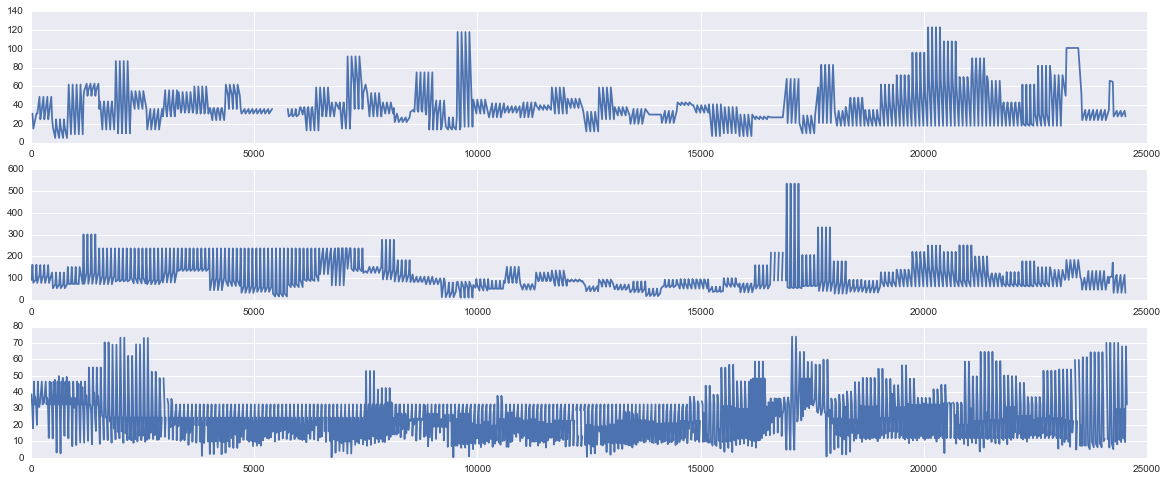

In [88]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(311)
ax1.plot(rawdata[rawdata['metric'] == 'Particulate Matter < 2.5 µg']['reading'])
ax2 = fig.add_subplot(312)
ax2.plot(rawdata[rawdata['metric'] == 'Particulate Matter < 10 µg']['reading'])
ax2 = fig.add_subplot(313)
ax2.plot(rawdata[rawdata['metric'] == 'Ozone']['reading'])

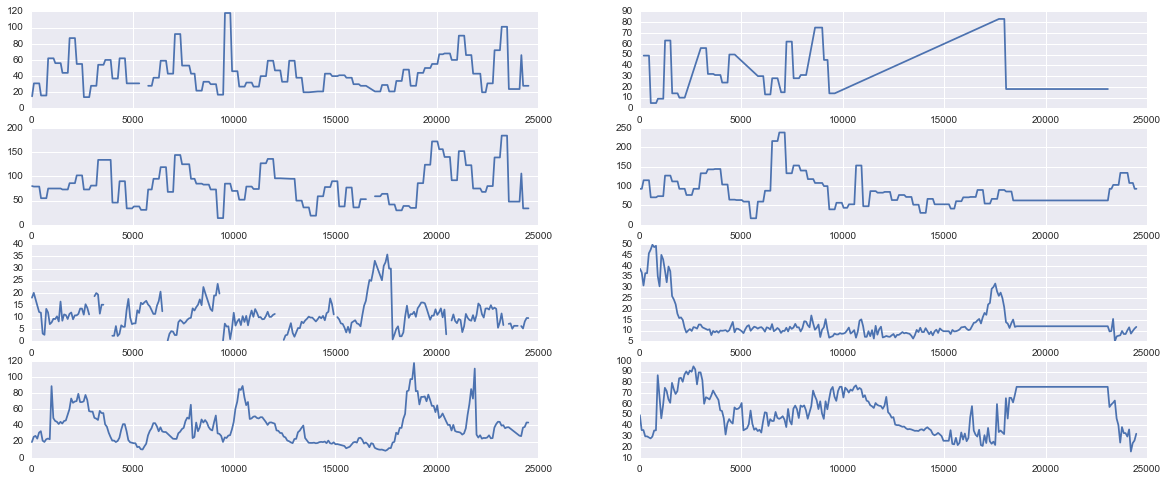

In [89]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(421)
ax1.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(423)
ax2.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(425)
ax2.plot(rawdata[(rawdata['metric'] == 'Ozone') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(427)
ax2.plot(rawdata[(rawdata['metric'] == 'Nitrogen Dioxide') & (rawdata['location'] == 'RK Puram')]['reading'])

ax1 = fig.add_subplot(422)
ax1.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(424)
ax2.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(426)
ax2.plot(rawdata[(rawdata['metric'] == 'Ozone') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(428)
ax2.plot(rawdata[(rawdata['metric'] == 'Nitrogen Dioxide') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])

In [146]:
def getReadings(metrics, location=None):
    allReadings = []
    if location == None:
        rd = rawdata
    else:
        rd = rawdata[rawdata['location'] == location]
    for m in metrics:
        allReadings.append(rd[rd['metric'] == m]['reading'])
    return pd.DataFrame(allReadings)

In [ ]:
sn.pairplot(getReadings(['Ozone', 'Nitrogen Dioxide']))

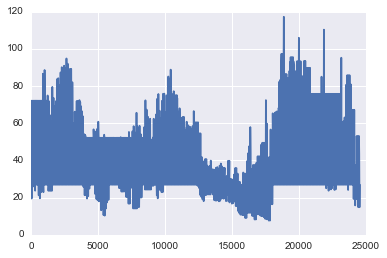

In [127]:
plt.plot(rawdata[rawdata['metric'] == 'Nitrogen Dioxide']['reading'])

In [106]:
data = rawdata[['location', 'metric', 'ts', 'reading']].dropna()
data.groupby(['location', 'metric']).describe()

reading
location    metric                               
Anand Vihar Ambient Temperature count  279.000000
                                mean    30.913262
                                std      2.303689
                                min     27.600000
                                25%     28.800000
                                50%     31.400000
                                75%     32.200000
                                max     37.000000
            Ammonia             count  276.000000
                                mean    42.236232
                                std     17.717709
                                min     18.800000
                                25%     33.400000
                                50%     34.400000
                                75%     44.225000
                                max    101.600000
            Barometric Pressure count  279.000000
                                mean   740.000000
                                std      0.000000
                                min    740.000000
                                25%    740.000000
                                50%    740.000000
                                75%    740.000000
                                max    740.000000
            Benzene             count  276.000000
                                mean     6.300000
                                std      5.541447
                                min      0.900000
                                25%      2.500000
                                50%      5.900000
...                                           ...
RK Puram    Toluene             std      4.610904
                                min      0.400000
                                25%      1.500000
                                50%      3.500000
                                75%      6.100000
                                max     18.100000
            Vertical Wind Speed count  203.000000
                                mean     0.139409
                                std      0.148669
                                min      0.100000
                                25%      0.100000
                                50%      0.100000
                                75%      0.200000
                                max      2.100000
            Wind Direction      count  279.000000
                                mean   182.666667
                                std     69.570832
                                min     16.000000
                                25%    138.500000
                                50%    156.000000
                                75%    246.500000
                                max    349.000000
            p-Xylene            count  242.000000
                                mean     2.178926
                                std      2.419288
                                min      0.100000
                                25%      0.700000
                                50%      1.200000
                                75%      2.475000
                                max      9.300000

[664 rows x 1 columns]